### Proyecto 2 - Ciencia de datos

Integrentes: 

- Karina Valladares, 18005 

- Alexa Bravo, 18831

- José Eduardo López, 181045

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neattext as nt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import textdistance
import re

from sklearn.cluster import AgglomerativeClustering  

In [2]:
data =pd.read_csv("train.csv")

data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
data.isna().sum().to_frame()

,0
id,0
keyword,61
location,2533
text,0
target,0


### Variables

- id: hace referencia a un número único para cada registro, es de tipo numérico (no necesita limpieza). 
    Tenemos 0 datos faltantes. 
- Keyword: es una palabra que caracteriza al tweet, no todos los tweets lo tienen pero no escencial para el análisis de texto, aunque puede resultar de gran ayuda para aquellos tweets que si estén vinculados a una. Es de tipo String y solo necesitamos remover los signos de puntuación y pasar todo a mayúsuculas. Tenemos 61 datos faltantes. 
- Location: hace referencia al país desde el que se publicó el tweet, no todos los registros tienen esta variables pero puede ser de utilidad para los que si la tienen. Para la limpieza solo es necesario estandarizar los nombres y colocar todo en mayúsculas. Tenemos 2,533 datos faltantes.
- text: es el mensaje de texto adjunto al tweet, esta es la variable más importante y la quiere mayor limpieza. Como es una variable que contiene texto es necesaria procesar como lenguaje natural, quitar caracteres especiales, correos, números de teléfono, stopwrods, signos de puntuación, pasar todo a mayúsculas, remover URL, entre otros. Tenemos 0 datos faltantes
- targe: es una variable binaria que clasifica si el tweet es sobre un desastre real: 1, 0 en caso contrario, no requiere limpieza. Tenemos 0 datos faltantes.

## Análisis Exploratorio

In [4]:
final_string = ""
for i in data["keyword"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

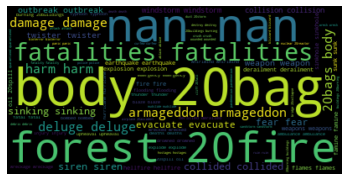

In [5]:
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos observar que aparecen valores repetidos y varios "NaN" por ello es necesario hacer limpieza y estandarizar los datos.

In [6]:
final_string = ""
for i in data["location"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

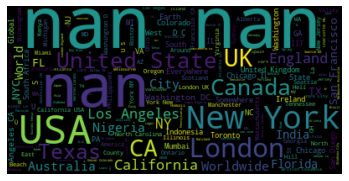

In [7]:
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos observar que aparecen valores repetidos y varios "NaN" por ello es necesario hacer limpieza y estandarizar los datos.

In [8]:
final_string = ""
for i in data["text"]:
    final_string += str(i) + " "
final_string = final_string[:-1]

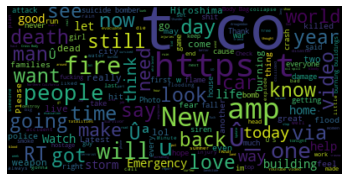

In [9]:
wordcloud = WordCloud().generate(str(final_string))

plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos observar que aparecen valores repetidos y varios "NaN" por ello es necesario hacer limpieza y estandarizar los datos.

In [10]:
pie = data.groupby("target").count()

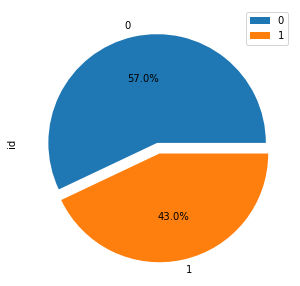

In [11]:
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))

In [12]:
keyword = data["keyword"]

In [72]:
def convertir_mayus(X):
    
    return X.str.upper()

def limpiar(X):
    for i in range(len(X)):
        X[i] = nt.TextFrame(str(X[i])).remove_stopwords(lang = "en")
        X[i] = nt.TextFrame(str(X[i])).remove_emails()
        X[i] = nt.TextFrame(str(X[i])).remove_numbers()
        X[i] = nt.TextFrame(str(X[i])).remove_phone_numbers()
        X[i] = nt.TextFrame(str(X[i])).remove_btc_address()
        X[i] = nt.TextFrame(str(X[i])).remove_urls()
        X[i] = nt.TextFrame(str(X[i])).remove_emojis()
        X[i] = nt.TextFrame(str(X[i])).remove_html_tags()
        X[i] = nt.TextFrame(str(X[i])).remove_puncts()
        X[i] = nt.TextFrame(str(X[i])).remove_special_characters()
        X[i] = nt.TextFrame(str(X[i])).remove_stopwords(lang = "es")
    
    return X

def normalize(text):
    return re.sub('[^a-z0-9]+', ' ', text.lower())

def group_texts(texts, threshold=0.4): 
    
    normalized_texts = np.array([normalize(text) for text in texts])
    distances = 1 - np.array([[textdistance.jaro_winkler(one, another) for one in normalized_texts] for another in normalized_texts])
    clustering = AgglomerativeClustering(distance_threshold=threshold,affinity="precomputed", linkage="complete", n_clusters=None).fit(distances)
    centers = dict()
    for cluster_id in set(clustering.labels_):
        index = clustering.labels_ == cluster_id
        centrality = distances[:, index][index].sum(axis=1)
        centers[cluster_id] = normalized_texts[index][centrality.argmin()]
    return [centers[i] for i in clustering.labels_]

### Pasamos todo a mayúsculas

In [14]:
keyword = convertir_mayus(keyword)

### Removemos Stopwords, emails, números, números de teléfono, direcciones. URL, emojis, HTML tags

In [15]:
keyword = limpiar(keyword)

In [16]:
data["keyword"] = keyword.astype(str)

In [17]:
data.groupby("keyword").count()

,id,location,text,target
keyword,,,,
ABLAZE,36,29,36,36
ACCIDENT,35,28,35,35
AFTERSHOCK,34,25,34,34
AIRPLANEACCIDENT,35,29,35,35
AMBULANCE,38,26,38,38
...,...,...,...,...
WOUNDS,33,27,33,33
WRECK,37,27,37,37
WRECKAGE,39,28,39,39


In [18]:
location = data["location"]

### Pasamos todo a mayúsculas

In [19]:
location = convertir_mayus(location)

### Removemos Stopwords, emails, números, números de teléfono, direcciones. URL, emojis, HTML tags

In [20]:
location = limpiar(location)

In [21]:
data["location"] = location.astype(str)

In [22]:
data.groupby("location").count()

,id,keyword,text,target
location,,,,
,302,302,302,302
A PROPERTY UNIVERSE,1,1,1,1
AARHUS CENTRAL JUTLAND,1,1,1,1
AAS AZTEC PRINCESS,1,1,1,1
AB CANADA,1,1,1,1
...,...,...,...,...
ZERO BRANCO,1,1,1,1
ZIAM AF,1,1,1,1
ZIMBABWE,1,1,1,1


In [23]:
text = data["text"]

### Pasamos todo a mayúsculas

In [24]:
text = convertir_mayus(text)

### Removemos Stopwords, emails, números, números de teléfono, direcciones. URL, emojis, HTML tags

In [25]:
text = limpiar(text)

In [26]:
data["text"] = text.astype(str)

In [27]:
data.groupby("text").count()

,id,keyword,location,target
text,,,,
A NIGHTMARE ELM STREET GETTING REMADE,1,1,1,1
A RADAR UPDATE WIDESPREAD SHOWERSSTORMS MOVING AREASMINOR FLOODING POSSIBLE HUNWX,1,1,1,1
A SLAMMING DOOR LESSON LEARNED LET LOVER CRASH BURN,1,1,1,1
A STARTED WRITING TALK TRAUMA THERAPY WAY COMMUNICATE GRAVITYCHAT,1,1,1,1
A VOLUNTARY EVACUATION RECOMMENDED TIME PICKEREL LAKE CABINS HIGHWAY REIDLAKE FIRE SAYS MACA NWT YZF,1,1,1,1
...,...,...,...,...
ZOUMA ABSOLUTELY FLATTENED GUY,1,1,1,1
ZOUMA FLATTENED CFC,1,1,1,1
ZOUMA FLATTENED GUY,1,1,1,1


In [38]:
location = data["location"]

In [79]:
def limpiar_na(X):
    resultado = []
    for i in range(len(X)):
        if str(X[i]) == "NAN":
            resultado.append("NO DATA")
        else:
            resultado.append(X[i])
    return resultado


In [59]:
resultado = group_texts(location, 0.6)

In [81]:
data["location"] = resultado

In [82]:
data["location"] = data["location"].str.upper()

In [83]:
X = data["location"]

In [84]:
X = limpiar_na(X)

In [85]:
data["location"] = X

In [86]:
data.groupby("location").count()

,id,keyword,text,target
location,,,,
,302,302,302,302
AIRES ARGENTINA,32,32,32,32
ALBERTA,56,56,56,56
AMERICA,20,20,20,20
AMERICAN WASTELAND MV,20,20,20,20
...,...,...,...,...
WELLINGTON,19,19,19,19
WEST COAST,23,23,23,23
WILLIAMSBURG,9,9,9,9
